<a href="https://colab.research.google.com/github/Chrisini/DecentNet/blob/master/main_concept_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ℂ𝕠𝕟𝕔𝕖𝕡𝕥 𝔼𝕩𝕥𝕣𝕒𝕔𝕥𝕚𝕠𝕟

* extract patches + equivalent segmentation masks patches (these are only used to analyse the clusters for research purposes; will not be avialable in real life)
* feature extraction
* clustering
* limit number of patches per cluster (randomly choose)
* concept tiling


Todos before running:
* [ ] check n_patches_per_cluster
* [ ] check whether we use the whole dataset
* [ ] check n_clusters
* [ ] check whether all function calles are set to true

Colours: 
* 018181 teal
* B0EFEE paleturquoise
* CD1285 mediumvioletred

Remaining questions: 
* how to compare the cluster quality for different runs
* have to fix naming convention for: {self.prefix}/patch_arrays, patch_id

Todos:
* [ ] evaluation on amd vs non-amd (boxplot), macula vs non-macula (boxplot) - need percentage per cluster 30% amd, 70% non amd, ...


idea (unrelated): monte carlo dropout only dropout in fc layers, don't need to put the image through the network multiple times - just once, and through the fc layers multiple times with different dropouts

# Configs

In [1]:
# if biggest_cluster_size is smaller than n_patches_per_cluster -> n_patches_per_cluster = biggest_cluster_size
n_patches_per_cluster = 2500 # should be 2500

# number of concepts aka number of DecentBlocks
n_clusters = 10

# resize, according to training of DecentNet
dst_img_size=500

# patch size
dst_patch_size=30

# overlapping of patch extraction
overlap_ratio_extract=0.2

# only use 5 images
reduced_data = True

# patch extraction type
# feature extraction type
# clustering type

# run functions yes/no
run_extract_patches = True

run_extract_features = False
run_cluster_patches = False


run_concepts_from_masks = True

run_concept_tiling = True

run_boxplot_evaluation = True
run_deepdream_evaluation = True

# prefix for experiments, use "tmp" for testing
prefix = "tmp"

base_path = r"C:\Users\Prinzessin\projects\decentnet" # r"C:/Users/Christina/Documents/decentnet"

# Imports

In [2]:
if False:
    # install torch dreams
    !pip install torch-dreams  --upgrade
from torch_dreams import Dreamer
from torch_dreams.custom_image_param import CustomImageParam

import random
import math
import time
import os
import glob
import heapq # needed for quilting?
import sys
import gc # garbage collector
import pickle # dump data
import shutil # delete dirs 

# data
import cv2
from PIL import Image
import skimage
from skimage import io, transform
import numpy as np
import pandas as pd

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# reduction and cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

# torch
import torch
import torch.nn as nn
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights

if not os.path.exists(base_path):
    os.makedirs(base_path)
os.chdir(base_path)

# Super Extractor Class

In [3]:
class ConceptExtractor():
    # =============================================================================
    # generic functions
    # =============================================================================

    def reset_dirs(self, result_paths: list):
        # create new dir or remove all files from dir
        for p in result_paths:
            if os.path.exists(p):
                shutil.rmtree(p)
            os.makedirs(p)
                
    def reset_files(self, file_names: list):
        for f in file_names:
            if os.path.isfile(f):
                os.remove(f) 
            p = os.path.dirname(f)
            if not os.path.exists(p):
                os.makedirs(p)

    def img_resize(self, img, size):
        # center crop
        crop_number = int( abs(img.shape[0]-img.shape[1]) /2 )
        if img.shape[0] < img.shape[1]:
            img = img[0:img.shape[0], crop_number:img.shape[1]-crop_number]
        else:
            img = img[crop_number:img.shape[0]-crop_number, 0:img.shape[1]]
        # resize
        img = skimage.transform.resize(img, (size, size))
        return img

    def load_csv(self, path:str):
        # =============================================================================
        # csv with index (patch_id) in position zero
        # =============================================================================
        csv_file = pd.read_csv(path, index_col=0)
        return csv_file

# Extract Patches

Comparison of segmentation and superpixel algorithms: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html

* overlapping patches

Todo: 
* [ ] save patches as 3D multichannel TIFF (plane, row, column, channel) 
https://scikit-image.org/skimage-tutorials/lectures/three_dimensional_image_processing.html


In [4]:
class PatchExtractor(ConceptExtractor):
    # =============================================================================
    # Single Image to patches - make batch size = 1 for dataloader
    # Masks to "patch histograms" aka, count black pixels (single number for each mask)
    # exclude patches that have no information in original image

    # img, mask, img_patch, mask_patch
    # =============================================================================
    def __init__(self, dst_img_size:int=None, dst_patch_size:int=30, overlap_ratio:float=0.2, reduced_data:bool=False):

        self.prefix = prefix
        
        self.dst_img_size = dst_img_size
        self.dst_patch_size = dst_patch_size 
        self.overlap = int(self.dst_patch_size * overlap_ratio)

        self.patches_of_this_img = [] # for plotting
                
        # ----------
        # inputs
        # ----------
        # do not add prefix here, due to original data
        # images
        train_base_path =   r"data/images/train/*/*" # /[amd,non-amd]/file.jpg
        image_paths = glob.glob(train_base_path)
        # path dataset, columns: image_path, basename (of image)
        self.path_df = pd.DataFrame({'image_path': image_paths})
        self.path_df["basename"] = self.path_df["image_path"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
        if reduced_data:
            self.path_df = self.path_df[:5] # xxxxx
        # segmentation masks for cluster evaluation
        scar_path =       r"data/masks/Lesion_Masks/scar/*"
        hemorrhage_path = r"data/masks/Lesion_Masks/hemorrhage/*"
        exudate_path =    r"data/masks/Lesion_Masks/exudate/*"
        drusen_path =     r"data/masks/Lesion_Masks/drusen/*"
        others_path =     r"data/masks/Lesion_Masks/others/*"
        disc_path =       r"data/masks/Disc_Masks/*"
        vessel_path =     r"data/masks/Vessel_Masks_Thresholded/*"
        # mask dict, get all mask paths from dirs
        self.mask_paths = {"lbl_Scars" : glob.glob(scar_path), # scars mask paths
                           "lbl_Hemorrhages": glob.glob(hemorrhage_path), # hemorrhage mask paths
                           "lbl_Exudates": glob.glob(exudate_path), # exudate mask paths, 
                           "lbl_Drusen": glob.glob(drusen_path), # drusen mask paths
                           "lbl_Other_Lesions": glob.glob(others_path), # other lesions mask paths
                           "lbl_Optic_Disc": glob.glob(disc_path), # optic disc mask paths
                           "lbl_Vessels" : glob.glob(vessel_path) # vessel mask paths
                           }
        
        # ----------
        # outputs
        # ----------
        self.patches_path = f"data/{self.prefix}/patch_arrays" # reset and fill
        self.csv_masks_info = f"results/{self.prefix}/masks_info.csv" # only delete specific file
        self.reset_dirs([self.patches_path])
        self.reset_files([self.csv_masks_info])

    def extract_sift_patches():
        pass
    
    def extract_graphcut_patches():
        pass

    def extract_overlapping_patches(self, img, masks_dict:dict, basename:str):
        # =============================================================================
        # go through coordinates of image, overlapping
        # extract image patches 
        #  - get image patchs
        #  - save each image patch as jpg
        # extract mask patches
        #  - get mask patches (for each mask)
        #  - save black pixel sum in patch file with patch ID (for each mask patch)
        # =============================================================================

        # reset for each image
        self.patches_of_this_img = []
        masks_patch_info = {}

        patch_id = None
        save_patch_path = None

        patch_counter = 0
        img_w, img_h, _ = img.shape
        
        # the maths: reset y
        y_max = y_min = 0

        def process_this_patch(x_minimum:int, x_maximum:int, y_minimum:int, y_maximum:int, counter:int, amd:bool):
            # =============================================================================
            # check whether at least half of the image patch has information (!= black)
            # save image patch as jpg with patch id
            # store in dict:
            #  - patch id (id)
            #  - mask type (header)
            #  - percentage of black pixels of current patch and mask type (values)
            # =============================================================================
            # extract image patch
            this_img_patch = img[x_minimum:x_maximum, y_minimum:y_maximum, :] # 3 channels
            # check whether image patch contains information
            # if amount black pixels is less than half of all pixels
            has_info = (this_img_patch == 0).astype(int).sum() < int(len(this_img_patch)/2)
            if has_info:
                # generate patch id
                patch_id = f"{basename}_{counter}"
                # for plotting
                self.patches_of_this_img.append((this_img_patch * 255).astype(np.uint8))
                # dict in dict: patch_id, mask type, value
                masks_patch_info[patch_id] = {}
                for key in self.mask_paths.keys():
                    
                    # if mask available
                    if masks_dict[key] is not None:
                        # extract mask patch
                        this_mask_patch = masks_dict[key][x_minimum:x_maximum, y_minimum:y_maximum] # 1 channel
                        # get percentage of black pixels in image
                        percent_black_pixels = int((  (this_mask_patch == 0).astype(int).sum() / len(this_mask_patch.flatten())  ) * 100)
                        # round to nearest 5
                        percent_black_pixels = 5 * round(percent_black_pixels/5)
                        masks_patch_info[patch_id][key] = percent_black_pixels
                    else:
                        # otherwise percentage is zero
                        masks_patch_info[patch_id][key] = 0

                if amd == True:
                    #masks_patch_info[patch_id]["lbl_amd"] = 100
                    pass
                else:
                    pass
                    #masks_patch_info[patch_id]["lbl_amd"] = 0
                
                # need to fill macula center in patch here TODO todo TODO todo TODO
                #masks_patch_info[patch_id]["lbl_macula"] = 0

                counter=counter+1

            return counter
            # =============================================================================

        if "A" in basename:
            amd = True
        elif "N" in basename:
            amd = False
        else:
            amd = None

        # iterate through img coordinates
        while y_max < img_h:
            # the maths: reset x, get max y value
            x_min = x_max = 0
            y_max = y_min + self.dst_patch_size
            while x_max < img_w:
                # the maths: get max x value
                x_max = x_min + self.dst_patch_size
                if y_max > img_h or x_max > img_w:
                    # the maths: border
                    xmax = min(img_w, x_max)
                    ymax = min(img_h, y_max)
                    xmin = max(0, xmax - self.dst_patch_size)
                    ymin = max(0, ymax - self.dst_patch_size)
                    # call function
                    patch_counter = process_this_patch(xmin, xmax, ymin, ymax, patch_counter, amd)
                else:
                    # call function
                    patch_counter = process_this_patch(x_min, x_max, y_min, y_max, patch_counter, amd)
                # the maths for width
                x_min = x_max - self.overlap
            # the maths for height
            y_min = y_max - self.overlap

        gc.collect()
        return masks_patch_info

    def plot(self, img):
        # =============================================================================
        # =============================================================================
        plt.figure()
        plt.imshow(img)
        row = col = 0
        n_patches = len(self.patches_of_this_img)

        if n_patches != 0:
            n_patches_sqrt = math.ceil(math.sqrt(n_patches))

            fig, ax = plt.subplots(n_patches_sqrt, n_patches_sqrt, figsize=(10, 10), sharex=True, sharey=True)
            for i, patch in enumerate(self.patches_of_this_img):
                if i >= n_patches:
                    break
                ax[row, col].imshow(patch)
                row += 1
                if row % n_patches_sqrt == 0:
                    col += 1
                    row = 0
            for a in ax.ravel():
                a.set_axis_off()
            plt.tight_layout()
            plt.show()
        else:
            print("Decent Info: In order to plot patches, you have to run process_patches first")

        gc.collect()

    def load_image_and_masks(self, image_path:str, basename:str):
        # =============================================================================
        # read image
        # read all masks, matching the image's basename
        # =============================================================================

        img = None
        masks_dict = {}
        
        # read image - 3 channels
        img = skimage.io.imread(image_path, as_gray=False)
        if self.dst_img_size is not None:
            img = self.img_resize(img, self.dst_img_size)

        # read masks
        for key, value_list in self.mask_paths.items():
            
            # get only mask path that contains basename
            mask_path = next((value for value in value_list if basename in value), None)

            if mask_path is not None and isinstance(mask_path, str):
                # read mask - 1 channel                
                masks_dict[key] = skimage.io.imread(mask_path, as_gray=True)
                # resize
                if self.dst_img_size is not None:
                    masks_dict[key] = self.img_resize(masks_dict[key], self.dst_img_size)
            else:
                masks_dict[key] = None

        gc.collect()
        return img, masks_dict

    def __len__(self):
        return len(self.path_df["image_path"])

    def __getitem__(self, idx:int):

        if idx == len(self): raise StopIteration 

        basename = self.path_df["basename"][idx]
        image_path = self.path_df["image_path"][idx]

        img, masks_dict = self.load_image_and_masks(image_path, basename)
        masks_patch_info = self.extract_overlapping_patches(img, masks_dict, basename)    

        # save this image patch
        save_patch_path = os.path.join(self.patches_path, basename+".tiff")
        #im = Image.fromarray((this_img_patch * 255).astype(np.uint8))
        #im.save(save_patch_path)

        stacked_img = None 
        #print(self.patches_of_this_img.shape)

        stacked_img = np.stack(self.patches_of_this_img, axis=0)

        # self.plot(img)
                               
        #print("plane, row, column, channel")
        #print(stacked_img.shape)
        io.imsave(save_patch_path, stacked_img, plugin="tifffile")

        # print(save_patch_path)

        return masks_patch_info

def extract_patches(dst_img_size:int=None, dst_patch_size:int=30, overlap_ratio:float=0.2, reduced_data:bool=False):
    # =============================================================================
    # FUNCTION CALL TO EXTRACT PATCHES
    # - iteration through dataset
    # - save patches with ID as png (for clustering, quilting)
    #
    # here: save patch id and mask patch info as csv (for evaluation of clusters)
    # =============================================================================

    patch_extractor = PatchExtractor(dst_img_size=dst_img_size, dst_patch_size=dst_patch_size, overlap_ratio=overlap_ratio, reduced_data=reduced_data)
    first_iter = True

    # key = "lbl_" + key
    
    # concat the dataframes of patches of all images
    for masks_patch_info in patch_extractor:
        if first_iter is False:
            df_new = pd.DataFrame.from_dict(masks_patch_info, orient='index')
            frames = [df, df_new]
            df = pd.concat(frames)  
        else: 
            df = pd.DataFrame.from_dict(masks_patch_info, orient='index')
            first_iter = False

    # save patch id and percentage of black pixels for each mask
    df.to_csv(patch_extractor.csv_masks_info, index=True, header=True)

    print(df.head())


# A. Concepts from Clustered Features

## Feature Extractor
1. Method: Pretrained model without fc head
1. Method: resize and flatten (very simple)
1. Method: Pretrained VAE (in progress)
1. Method: Traditional feature extraction (in progress)
1. Method: Unsupervised contrastive learning (in progress)


PCA: If the number of features is larger than the number of samples, then you will be dealing with the “curse of dimensionality”, and your k-means algorithm will not produce good results.


In [5]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
        

class FeatureExtractorModel(nn.Module):
    def __init__(self):
        super(FeatureExtractorModel, self).__init__()
        self.fem = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
        self.fem.fc = nn.Identity()

    def forward(self, img):
        return self.fem(img)

In [6]:
class FeatureExtractor(ConceptExtractor):
    def __init__(self):
        
        self.prefix = prefix
    
        self.feature_vector = []

        # feature extraction model
        self.model = FeatureExtractorModel().to(device)
        self.weights = ShuffleNet_V2_X1_0_Weights.DEFAULT
        self.preprocess = self.weights.transforms()
        self.model.eval()
        
        # ----------
        # inputs
        # ----------
        patches_path = f"data/{self.prefix}/patch_arrays/*"
        patch_array_paths = glob.glob(patches_path) 

        # path dataset, columns: patch_array_path, basename
        self.path_df = pd.DataFrame({'patch_array_path': patch_array_paths})
        self.path_df["basename"] = self.path_df["patch_array_path"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

        # ----------
        # outputs
        # ----------
        self.features_file_path = f"results/{self.prefix}/features.csv"
        self.pca95_model_path   = f"results/{self.prefix}/ckpts/pca95model.pkl"
        self.reset_files([self.features_file_path, self.pca95_model_path])
        

    def load_patches(self, patch_array_path:str):
        # =============================================================================
        # read patches of this img -  plane (~330), row (30), column (30), channels (3)
        # =============================================================================
        patches_of_this_img = skimage.io.imread(patch_array_path, as_gray=False)
        return patches_of_this_img

    def vector_from_flattening(self, patch):
        # =============================================================================
        # Method: use simple resize and flatten to get feature vector
        # =============================================================================
        feature_vector = self.img_resize(patch.copy(), 10) 
        feature_vector = feature_vector.flatten() 
        return feature_vector

    def vector_from_pretrained_model(self, patch):
        # =============================================================================
        # Method: use pretrained model to get feature vector
        # =============================================================================
        processed_patch = self.preprocess(torch.tensor(patch).permute(2, 0, 1))
        with torch.no_grad():
            feature_vector = self.model(processed_patch.unsqueeze(0).to(device))
        # When detach is needed, you want to call detach before cpu.     
        feature_vector = feature_vector.detach().cpu().flatten().numpy()
        return feature_vector

    def vector_from_contrastive_learning(self, patch):
        pass

    def vector_from_autoencoder(self, patch):
        pass

    def vector_from_filters(self, patch):
        pass

    def __len__(self):
        # for each image patches array
        return len(self.path_df["patch_array_path"])

    def __getitem__(self, idx:int):

        if idx == len(self): raise StopIteration 

        patch_array_path = self.path_df["patch_array_path"][idx]
        patches = self.load_patches(patch_array_path)
        
        patch_array_feature_vectors = []
        patch_array_ids = []
        for i, patch in enumerate(patches):
            patch_array_feature_vectors.append( self.vector_from_pretrained_model(patch) )
            patch_array_ids.append( self.path_df["basename"][idx] + "_" + str(i) )

        return patch_array_feature_vectors, patch_array_ids

def extract_features():
    # =============================================================================
    # FUNCTION CALL TO CLUSTER PATCHES
    # - feature extraction
    # - pca for dimensionality reduction
    #
    # here: save patch id and feature vector as csv (for clustering)
    # =============================================================================
    
    feature_extractor = FeatureExtractor()

    feature_vectors = []
    patch_ids = []
    for patch_array_feature_vectors, patch_array_ids in feature_extractor:
        feature_vectors.extend(patch_array_feature_vectors)
        patch_ids.extend(patch_array_ids)

    # change type
    feature_vectors = np.asarray(feature_vectors)
    feature_vectors = feature_vectors.astype(np.float32)

    # select the number of components while preserving 99% of the variability in the data
    pca95 = PCA(n_components=0.99, random_state=19)
    pca95.fit(feature_vectors)
    pca95_feature_vectors = pca95.transform(feature_vectors)

    with open(feature_extractor.pca95_model_path, "wb") as f:
        pickle.dump(pca95, f)

    df = pd.DataFrame(data=pca95_feature_vectors, 
                      columns=list(range(len(pca95_feature_vectors[0]))), 
                      index=patch_ids)

    # save patch id and feature vector as csv
    df.to_csv(feature_extractor.features_file_path, index=True, header=True)

    print(df.head())


## Clustering

* filtering could be done in a smarter way

In [7]:
class ClusterExtractor(ConceptExtractor):
    def __init__(self, n_patches_per_cluster:int=5000, n_clusters:int=10):
    
        # make sure to not use a clustering approach that removes outliers!!
        
        self.prefix = prefix
        
        self.n_patches_per_cluster = n_patches_per_cluster
        self.n_clusters = n_clusters

        self.unique_labels = []

        self.feature_vectors = []
        

        # ----------
        # input
        # ----------
        self.features_file_path =   f"results/{self.prefix}/features.csv"
        self.masks_info_path = f"results/{self.prefix}/masks_info.csv"
        self.patches_path = f"data/{self.prefix}/patch_arrays"

        self.features_csv = self.load_csv(self.features_file_path)
        self.masks_info_csv = self.load_csv(self.masks_info_path)  

        # ----------
        # output
        # ----------
        # dirs
        self.cluster_path = f"results/{self.prefix}/clusters" # visualised patches
        self.reset_dirs([self.cluster_path])
        # files
        self.filtered_masks_info_label_path = f"results/{self.prefix}/masks_info_label.csv"
        self.kmeans_model_path = f"results/{self.prefix}/ckpts/kmeans_model.pkl"
        self.reset_files([self.filtered_masks_info_label_path, self.kmeans_model_path])


    def run_meanshift_clustering(self, feature_vectors):
        # https://scikit-learn.org/stable/modules/clustering.html
        # class sklearn.cluster.MeanShift(*, bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=None, max_iter=300)
        pass

    def run_ward_clustering(self, feature_vectors):
        # https://scikit-learn.org/stable/modules/clustering.html
        # class sklearn.cluster.AgglomerativeClustering(n_clusters=2, *, affinity='deprecated', metric=None, memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)
        pass

    def run_gmm_clustering(self, feature_vectors):
        # https://scikit-learn.org/stable/modules/clustering.html
        # class sklearn.mixture.GaussianMixture(n_components=1, *, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)
        pass

    def run_nearest_neighbour(self, feature_vectors):
        # https://scikit-learn.org/stable/modules/neighbors.html
        pass

    def run_kmeans_clustering(self, feature_vectors):
        # https://scikit-learn.org/stable/modules/clustering.html

        # todo: could use Elbow Method for determining n_clusters

        # k means clustering
        kmeans_model = KMeans(n_clusters=self.n_clusters, random_state=19).fit(feature_vectors)
        labels = kmeans_model.predict(feature_vectors)

        with open(self.kmeans_model_path, "wb") as f:
            pickle.dump(kmeans_model, f)

        df = pd.DataFrame({"lbl_cluster": labels}, index=list(feature_vectors.index.values))

        self.unique_labels = list(np.unique(labels))
        return df

    def filter_clusters(self, df):
        # shuffled
        df = df.sample(frac=1) # .reset_index(drop=True)
        # get n rows for each label
        df = df.sort_values("lbl_cluster", ascending = False).groupby("lbl_cluster").head(self.n_patches_per_cluster)
        return df

    def plot_clusters(self, df):
        
        # for each cluster
        for label in self.unique_labels:

            patches_for_this_cluster = df.loc[df["lbl_cluster"] == label]
            if False:
                random.shuffle(patches_for_this_cluster)

            print(f"Cluster size {len(patches_for_this_cluster)}")

            # only allow up to x images to be shown at a time
            if len(patches_for_this_cluster) > 8:
                patches_for_this_cluster = patches_for_this_cluster[:8]

            fig, ax = plt.subplots(ncols=len(patches_for_this_cluster), figsize=(16,2), sharex=True, sharey=True)
            for i, (patch_id, patch) in enumerate(patches_for_this_cluster.iterrows()):
                print(patch_id)

                basename, i_patch = patch_id.split("_")

                patch = skimage.io.imread(os.path.join(self.patches_path, basename+".tiff"), as_gray=False)[int(i_patch)]
                ax[i].imshow(patch)
            for a in ax.ravel():
                a.set_axis_off()
            plt.tight_layout()
            plt.show()
            fig.savefig(os.path.join(self.cluster_path, f'{label}.png'))

    def __len__(self):
        # item only needed once
        return 1

    def __getitem__(self, idx:int):

        if idx == len(self): raise StopIteration 

        df = self.run_kmeans_clustering(self.features_csv)
        df = self.filter_clusters(df)

        self.plot_clusters(df)

        # only keeps mask info for filtered df samples
        df = pd.concat([df, self.masks_info_csv], axis=1, join="inner")

        # still a todo
        

        return df

def cluster_patches(n_patches_per_cluster:int=5000, n_clusters:int=10):
    # =============================================================================
    # FUNCTION CALL TO CLUSTER PATCHES
    # - clustering
    # - filter patches
    #
    # here: save patch id, mask info and cluster label as csv (for boxplot and quilting)
    # =============================================================================
    
    cluster_extractor = ClusterExtractor(n_patches_per_cluster=n_patches_per_cluster, n_clusters=n_clusters)
    # runs only one time
    for df in cluster_extractor:
        df.to_csv(cluster_extractor.filtered_masks_info_label_path, index=True, header=True)
        print(df.head())


In [8]:
#pd.read_csv(f"results/{prefix}/masks_info_label.csv")

# B. Concepts from Segmentation Masks

## Mask Concept Extractor

In [9]:
class MaskConceptExtractor(ConceptExtractor):
    # =============================================================================
    # generate a dataset with positive and negative cases for each mask type
    # focusing on filling this file: masks_info_label.csv
    # label: 1p, 1n, 2p, 2n, ...
    # =============================================================================
    
    def __init__(self, n_patches_per_cluster:int=5000):
        
        self.prefix = prefix
        
        # ----------
        # inputs
        # ----------
        
        self.masks_info_path = f"results/{self.prefix}/masks_info.csv"
        self.masks_info_csv = self.load_csv(self.masks_info_path)
        
        self.column_keys = self.masks_info_csv.columns.values
        
        print(self.masks_info_csv.columns.values )
        
        self.n_patches_per_cluster = n_patches_per_cluster
        
        
        # ----------
        # output
        # ----------
        # dirs
        self.cluster_path = f"results/{self.prefix}/clusters" # visualised patches
        self.reset_dirs([self.cluster_path])
        # files
        self.filtered_masks_info_label_path = f"results/{self.prefix}/masks_info_label.csv"
        self.reset_files([self.filtered_masks_info_label_path])    
    

    def __len__(self):
        # for each image patches array
        return 1

    def __getitem__(self, idx:int):

        if idx == len(self): raise StopIteration
        
        print(self.masks_info_csv.shape)
        
        dataframes = []
        for col_key in self.column_keys:
                        
            tmp_neg = self.masks_info_csv.loc[self.masks_info_csv[col_key] == 0].sample(frac=1)
            tmp_pos = self.masks_info_csv.loc[self.masks_info_csv[col_key] != 0].sample(frac=1)
            
            max_size = self.n_patches_per_cluster
            
            
            if len(tmp_neg[col_key]) < max_size:
                max_size = len(tmp_neg[col_key])
                
                
            if len(tmp_pos[col_key]) < max_size:
                max_size = len(tmp_pos[col_key])
                
                
            tmp_neg = tmp_neg[0:max_size][col_key]
            tmp_pos = tmp_pos[0:max_size][col_key]
                        
            tmp = pd.concat( [ tmp_neg, tmp_pos ] )
                        
            dataframes.append(tmp)
            
        result = pd.concat(dataframes, axis=1)
        
        result["lbl_cluster"] = 0
                
        

        return result

def concepts_from_masks(n_patches_per_cluster):
    # =============================================================================
    # Function call for extracting concepts from segmentation masks
    # =============================================================================
    
    
    
    concept_extractor = MaskConceptExtractor(n_patches_per_cluster)
    # runs only one time
    for df in concept_extractor:
        df.to_csv(concept_extractor.filtered_masks_info_label_path, index=True, header=True)
        print(df.shape)
        print(df.head())
    
    
    
    
    """
    feature_extractor = FeatureExtractor()

    feature_vectors = []
    patch_ids = []
    for patch_array_feature_vectors, patch_array_ids in feature_extractor:
        feature_vectors.extend(patch_array_feature_vectors)
        patch_ids.extend(patch_array_ids)

    # change type
    feature_vectors = np.asarray(feature_vectors)
    feature_vectors = feature_vectors.astype(np.float32)

    # select the number of components while preserving 99% of the variability in the data
    pca95 = PCA(n_components=0.99, random_state=19)
    pca95.fit(feature_vectors)
    pca95_feature_vectors = pca95.transform(feature_vectors)

    with open(feature_extractor.pca95_model_path, "wb") as f:
        pickle.dump(pca95, f)

    df = pd.DataFrame(data=pca95_feature_vectors, 
                      columns=list(range(len(pca95_feature_vectors[0]))), 
                      index=patch_ids)

    # save patch id and feature vector as csv
    df.to_csv(feature_extractor.features_file_path, index=True, header=True)

    print(df.head())
    """



# Quilted image generation
* immitating DeepDream
* quilting, using minimum cut and dijkstra's algorithm vertical

In [10]:
class QuiltExtractor(ConceptExtractor):
    # https://people.eecs.berkeley.edu/~efros/research/quilting/quilting.pdf
    # https://github.com/axu2/image-quilting/blob/master/Final_Project_COS429%20(1).ipynb

    def __init__(self,  patch_part:float=0.8, overlap_ratio:float=0.1, dst_img_size:int=500):
        # we want to get a 500x500 image
        # each patch is 30x30 big
        
        self.prefix = prefix

        self.end = self.start = 0

        # patch part: only take part of the patch e.g. 80% 
        self.patch_part = patch_part

        self.overlap_ratio = overlap_ratio

        # width and height of the result image
        self.image_size = dst_img_size
        

        # ----------
        # inputs
        # ----------
        self.filtered_masks_info_label_path = f"results/{self.prefix}/masks_info_label.csv" # label and patch id
        self.patch_id_label = self.load_csv(self.filtered_masks_info_label_path)[["lbl_cluster"]]
        self.patches_path = f"data/{self.prefix}/patch_arrays"
        
        # ----------
        # outputs
        # ----------
        self.concepts_path = f"data/{self.prefix}/concepts" # reset and fill
        self.reset_dirs([self.concepts_path])


    def run(self, patch_id, label):

        basename, i_patch = patch_id.split("_") # A0001_4_vessel
        self.patch = skimage.io.imread(os.path.join(self.patches_path, basename+".tiff"), as_gray=False)[int(i_patch)]
       
        self.start = time.time()
        
        # patch times 4 (with rotation)
        combined_patch = self.patch
        combined_patch = np.concatenate([combined_patch, np.flip(combined_patch, 0)], axis=0)
        combined_patch = np.concatenate([combined_patch, np.flip(combined_patch, 1)], axis=1)
        self.texture = combined_patch
        self.texture = skimage.util.img_as_float(self.texture)

        # 30 + 30
        # 60*0.8
        self.patch_length = math.ceil(min(self.texture.shape[:2])*self.patch_part)

        # overlap ratio: 60*0.8*0.1
        self.overlap = math.ceil(self.patch_length * self.overlap_ratio)

        # 60*0.8 - 60*0.8*0.1
        final_length = math.ceil(self.patch_length - self.overlap)

        # amount of patches we can have for the image size
        # 500 / (60*0.8 - 60*0.8*0.1)
        n_patches = math.ceil(self.image_size / final_length)

        # (60*0.8 - 60*0.8*0.1) * 11 + 5 (overlap)
        patch_dependent_image_size = math.ceil(final_length * n_patches) + self.overlap

        if False:
            print("overlap", self.overlap)
            print("final image size", patch_dependent_image_size)
            print("number of patches", self.n_patches)
            print("length of 1 patch before reduction", self.patch_length)
            print("length of 1 patch after", final_length)
            print("a", n_patches * final_length)
            print("b", n_patches * self.patch_length)

        # result image with result image size
        self.result_image = np.zeros((patch_dependent_image_size, patch_dependent_image_size, self.texture.shape[2]))

        for i in range(n_patches):
            for j in range(n_patches):
                y = i * final_length
                x = j * final_length

                if i == 0 and j == 0:
                    patch = self.randomPatch()
                else:
                    patch = self.randomPatch()
                    patch = self.minCutPatch(patch, x, y)

                
                self.result_image[y:y+self.patch_length, x:x+self.patch_length] = patch
        
        self.end = time.time()
        
    def plot(self):

        fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
        
        i = 0
        axs[i].imshow(self.patch)
        axs[i].set_title("Patch")
        axs[i].axis("off")
        
        i+=1
        axs[i].imshow(self.texture)
        axs[i].set_title("Combined")
        axs[i].axis("off")

        i+=1
        axs[i].imshow(self.result_image)
        axs[i].set_title("Quilted image")
        axs[i].axis("off")        
        
        plt.tight_layout()
        plt.show()

        print("^ Time needed for one patch: ", self.end - self.start)
        
    def save(self, patch_id, label):
        im = Image.fromarray((self.result_image * 255).astype(np.uint8))
        tmp = patch_id.split("_")[0]
        p = os.path.join(self.concepts_path, tmp) # "c"+str(label)
        if not os.path.exists(p):
            os.makedirs(p)
        im.save(os.path.join(p, f"dream_c{label}_{patch_id}.jpg"))
        
    def randomPatch(self):
        h, w, _ = self.texture.shape
        i = np.random.randint(h - self.patch_length)
        j = np.random.randint(w - self.patch_length)
        return self.texture[i:i+self.patch_length, j:j+self.patch_length]

    def dijkstra_algorithm(self, errors):
        # dijkstra's algorithm vertical
        pq = [(error, [i]) for i, error in enumerate(errors[0])]
        heapq.heapify(pq)

        h, w = errors.shape
        seen = set()

        while pq:
            error, path = heapq.heappop(pq)
            curDepth = len(path)
            curIndex = path[-1]

            if curDepth == h:
                return path

            for delta in -1, 0, 1:
                nextIndex = curIndex + delta

                if 0 <= nextIndex < w:
                    if (curDepth, nextIndex) not in seen:
                        cumError = error + errors[curDepth, nextIndex]
                        heapq.heappush(pq, (cumError, path + [nextIndex]))
                        seen.add((curDepth, nextIndex))

    def minCutPatch(self, patch, x, y):

        patch = patch.copy()
        dy, dx, _ = patch.shape
        minCut = np.zeros_like(patch, dtype=bool)

        if x > 0:
            left = patch[:, :self.overlap] - self.result_image[y:y+dy, x:x+self.overlap]
            leftL2 = np.sum(left**2, axis=2)
            for i, j in enumerate(self.dijkstra_algorithm(leftL2)): # errors
                minCut[i, :j] = True

        if y > 0:
            up = patch[:self.overlap, :] - self.result_image[y:y+self.overlap, x:x+dx]
            upL2 = np.sum(up**2, axis=2)
            for j, i in enumerate(self.dijkstra_algorithm(upL2.T)): # errors
                minCut[:i, j] = True

        np.copyto(patch, self.result_image[y:y+dy, x:x+dx], where=minCut)
        
        return patch

    def __len__(self):
        # amount of segmentation masks
        return len(self.patch_id_label)

    def __getitem__(self, idx:int):

        if idx == len(self): raise StopIteration 

        patch_id = self.patch_id_label.index[idx]
        label = self.patch_id_label["lbl_cluster"][idx]

        # for each cluster aka for each class label
        self.run(patch_id, label)
        self.save(patch_id, label)
        # self.plot()

def concept_tiling(dst_img_size:int=500):
    # patch-based texture synthesis

    quilt_extractor = QuiltExtractor(patch_part=0.8, overlap_ratio=0.1, dst_img_size=dst_img_size)

    # for each patch
    for _ in quilt_extractor:            
        pass

    print("done")


# Evaluation of clusters via boxplot

In [11]:
class BoxPlotExtractor(ConceptExtractor):
    def __init__(self):
        
        self.prefix = prefix
        
        # ----------
        # input
        # ----------
        self.filtered_masks_info_label_path = f"results/{self.prefix}/masks_info_label.csv"
        self.masks_info_label_csv = self.load_csv(self.filtered_masks_info_label_path)


        # segmentation types  
        header_keys = list(self.masks_info_label_csv.keys())
        self.seg_types=header_keys
        self.seg_types.remove("lbl_cluster")

        # class labels
        self.unique_classes = np.unique(self.masks_info_label_csv["lbl_cluster"])

        # biggest cluster size
        biggest_cluster_size = max(self.masks_info_label_csv["lbl_cluster"].value_counts())

        print(self.seg_types)

        self.combined_info = self.masks_info_label_csv
        self.combined_info["count"] = 1
        # combined_info = combined_info[(combined_info != 0).all(1)] # no idea

        # max size in boxplot value should be 1000 
        self.multiplier = 1000 / biggest_cluster_size


        # ----------
        # outputs
        # ----------
        self.boxplots_path = f"results/{self.prefix}/boxplots" # reset and fill
        self.reset_dirs([self.boxplots_path])

    def run(self, seg_type:str="Vessels"):
        # =============================================================================
        # 
        # =============================================================================

        # where lesion, optic disc, ...
        sub_info = self.combined_info[["lbl_cluster", f"{seg_type}", "count"]]

        # figure
        fig, ax = plt.subplots(figsize=(10, 7))

        # create subframe for each cluster
        boxplot_data = []
        for label in range(len(self.unique_classes)):
            
            filtered0 = sub_info.loc[sub_info["lbl_cluster"] == label][seg_type]
            # remove zero for boxplot
            filtered0 = [i for i in filtered0 if i != 0]
            boxplot_data.append(filtered0)

        # BOXPLOT
        ax = plt.boxplot(boxplot_data, medianprops=dict(color="mediumvioletred", linewidth=1.5), showfliers=False)
        
        # count values for each label
        # label, percentage, patch_id
        sub_info = sub_info.groupby(["lbl_cluster", f"{seg_type}"])["count"].count().reset_index()

        # SCATTER PLOT
        # uses absolute value for size which is great for consistency among plots
        ax = plt.scatter(  sub_info["lbl_cluster"]+1, sub_info[seg_type], s=sub_info["count"]*self.multiplier, alpha=0.7, c='paleturquoise', edgecolors="teal"  )

        # show and save figure
        plt.title(seg_type)
        plt.xlabel('Concept cluster ID')
        plt.ylabel(f'Percentage of "{seg_type}" pixels in image') 
        if "Vessel" in seg_type:
            plt.yticks(plt.np.arange(-10, 41, 10)) 
        else:
            plt.yticks(plt.np.arange(-10, 111, 10)) 
        plt.setp( plt.gca().get_yticklabels()[0], visible=False)
        plt.setp( plt.gca().get_yticklabels()[-1], visible=False)
        plt.show()
        fig.savefig(os.path.join(self.boxplots_path, f"{seg_type}.png"))


    def __len__(self):
        # amount of segmentation types
        return len(self.seg_types)

    def __getitem__(self, idx:int):

        if idx == len(self): raise StopIteration 
        seg_type = self.seg_types[idx]
        self.run(seg_type)

def evalutation_via_boxplot():

    boxplot_extractor = BoxPlotExtractor()

    # for each segmentation type
    for _ in boxplot_extractor:
        pass



# Evaluation of clusters via t-sne (in progress)

In [12]:
class tsneExtractor(ConceptExtractor):
    def __init__(self):
        
        self.prefix = prefix
        
        # ----------
        # input
        # ----------
        self.filtered_masks_info_label_path = f"results/{self.prefix}/masks_info_label.csv"
        self.masks_info_label_csv = self.load_csv(self.filtered_masks_info_label_path)


        # ----------
        # outputs
        # ----------
        self.tsne_path = f"results/{self.prefix}/tsne" # reset and fill
        self.reset_dirs([self.tsne_path])
        
        

    def run(self):
        # =============================================================================
        # todo: use this https://www.kaggle.com/code/aussie84/clustering-with-kmeans-pca-tsne
        # =============================================================================

        pass

        if False:
            # where lesion, optic disc, ...
            sub_info = self.combined_info[["lbl_cluster", f"{seg_type}", "count"]]

            # figure
            fig, ax = plt.subplots(figsize=(10, 7))

            # create subframe for each cluster
            boxplot_data = []
            for label in range(len(self.unique_classes)):
                
                filtered0 = sub_info.loc[sub_info["lbl_cluster"] == label][seg_type]
                # remove zero for boxplot
                filtered0 = [i for i in filtered0 if i != 0]
                boxplot_data.append(filtered0)

            # BOXPLOT
            ax = plt.boxplot(boxplot_data, medianprops=dict(color="mediumvioletred", linewidth=1.5))
            
            # count values for each label
            # label, percentage, patch_id
            sub_info = sub_info.groupby(["lbl_cluster", f"{seg_type}"])["count"].count().reset_index()

            # SCATTER PLOT
            # uses absolute value for size which is great for consistency among plots
            ax = plt.scatter(  sub_info["lbl_cluster"]+1, sub_info[seg_type], s=sub_info["count"]*self.multiplier, alpha=0.7, c='paleturquoise', edgecolors="teal"  )

            # show and save figure
            plt.title(seg_type)
            plt.xlabel('Concept cluster ID')
            plt.ylabel(f'Percentage of "{seg_type}" pixels in image') 
            plt.yticks(plt.np.arange(-10, 111, 10)) 
            plt.setp( plt.gca().get_yticklabels()[0], visible=False)
            plt.setp( plt.gca().get_yticklabels()[-1], visible=False)
            plt.show()
            fig.savefig(os.path.join(self.boxplots_path, f"{seg_type}.png"))


    def __len__(self):
        return 1

    def __getitem__(self, idx:int):

        if idx == len(self): raise StopIteration 

        a = 0
        self.run()

def evalutation_via_tsne():

    tsne_extractor = tsneExtractor()

    for _ in tsne_extractor:
        pass



# Evaluation of quilted images via DeepDream
* optimising an image for a specific channel in a layer

In [23]:
class DeepDreamExtractor(ConceptExtractor):
    # https://github.com/Mayukhdeb/torch-dreams/

    def __init__(self):
        
        self.prefix = prefix

        self.model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)

        #print(self.model)
        self.layers_to_use = [
                        self.model.conv1[0], 
                        self.model.stage2[1].branch2[5],
                        self.model.stage2[3].branch2[5],
                        self.model.stage4[1].branch2[5],
                        self.model.conv5[0]
                        ] 
        self.layers_to_use = [self.layers_to_use[1]]
        
        self.dreamy_boi = Dreamer(self.model, device = "cpu", quiet =  False)
        


        # ----------
        # input
        # ----------
        image_paths = f"data/{self.prefix}/concepts/*/*"
        self.image_path = glob.glob(image_paths)[4]
        self.param = CustomImageParam(image = self.image_path, device = "cpu")

    def run(self):

        def loss_from_layer_func(layer_number = 0, channel_number= 0): 
            def custom_func(layer_outputs):
                loss = layer_outputs[layer_number][channel_number].mean()
                return -loss
            return custom_func

        # Now in order to optimize the **7th channel** of the **first layer** mentioned in `layers_to_use` we define the custom loss as:
        func_call = loss_from_layer_func(layer_number= 0, channel_number = 6)

        self.image_param = self.dreamy_boi.render(
            image_parameter= self.param,
            layers = self.layers_to_use,
            lr = 2e-4, # PARAMETER
            iters = 200,  # PARAMETER
            custom_func = func_call
        )

    def plot(self):
        fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(10,5))
        try:
            ax.flat[0].imshow(cv2.cvtColor(cv2.imread(self.image_path), cv2.COLOR_BGR2RGB))
        except:
            ax.flat[0].imshow(cv2.imread(self.image_path))
            
        ax.flat[1].imshow(self.image_param)


def evalutation_via_deepdream():
    # todo, make iterative with loop for many images
    deep_dream_extractor = DeepDreamExtractor()
    deep_dream_extractor.run()
    deep_dream_extractor.plot()

# Function calls

In [24]:
if run_extract_patches:
    extract_patches(dst_img_size=dst_img_size, 
                    dst_patch_size=dst_patch_size, 
                    overlap_ratio=overlap_ratio_extract,
                    reduced_data=reduced_data)


KeyboardInterrupt: 

In [ ]:
if run_extract_features:
    extract_features()

In [16]:
if run_cluster_patches:
    cluster_patches(n_patches_per_cluster=n_patches_per_cluster, 
                    n_clusters=n_clusters)

In [17]:
if run_concepts_from_masks:
    concepts_from_masks(n_patches_per_cluster=n_patches_per_cluster)

['lbl_Scars' 'lbl_Hemorrhages' 'lbl_Exudates' 'lbl_Drusen'
 'lbl_Other_Lesions' 'lbl_Optic_Disc' 'lbl_Vessels']
(1661, 7)
(890, 8)
           lbl_Scars  lbl_Hemorrhages  lbl_Exudates  lbl_Drusen  \
A0002_77         0.0              NaN           NaN         NaN   
A0005_109        0.0              0.0           NaN         NaN   
A0002_182        0.0              0.0           NaN         NaN   
A0004_15         0.0              0.0           NaN         NaN   
A0001_296        0.0              NaN           NaN         NaN   

           lbl_Other_Lesions  lbl_Optic_Disc  lbl_Vessels  lbl_cluster  
A0002_77                 NaN             NaN          NaN            0  
A0005_109                NaN             0.0          NaN            0  
A0002_182                NaN             NaN          NaN            0  
A0004_15                 NaN             NaN          NaN            0  
A0001_296                NaN             NaN          NaN            0  


In [18]:
if run_concept_tiling:
    concept_tiling(dst_img_size=dst_img_size)

KeyboardInterrupt: 

['lbl_Scars', 'lbl_Hemorrhages', 'lbl_Exudates', 'lbl_Drusen', 'lbl_Other_Lesions', 'lbl_Optic_Disc', 'lbl_Vessels']


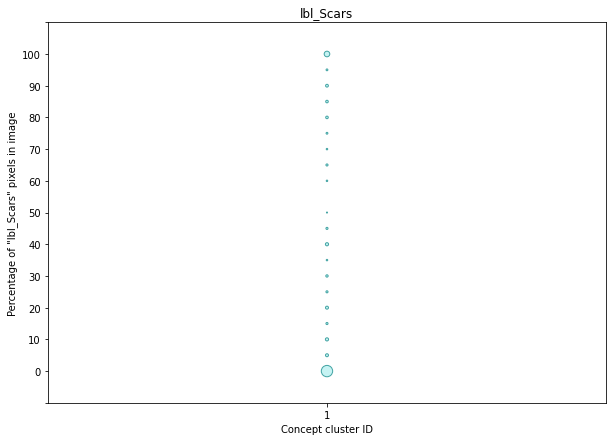

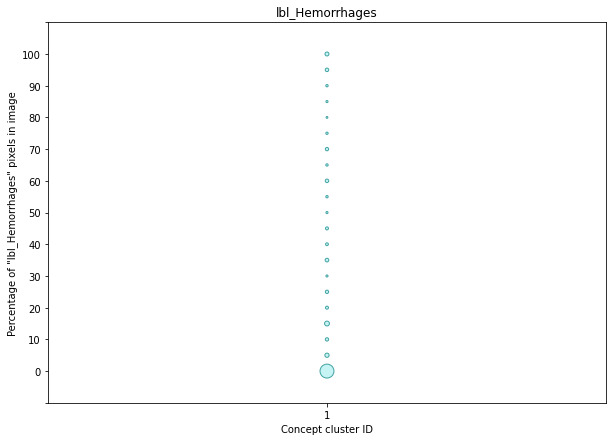

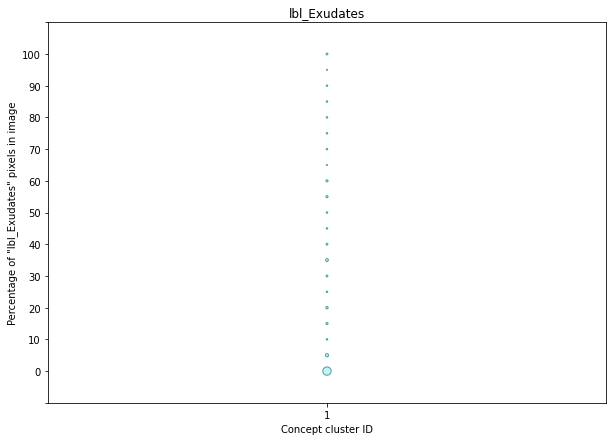

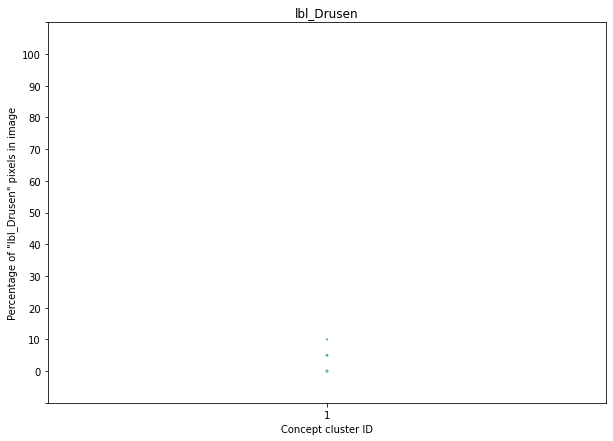

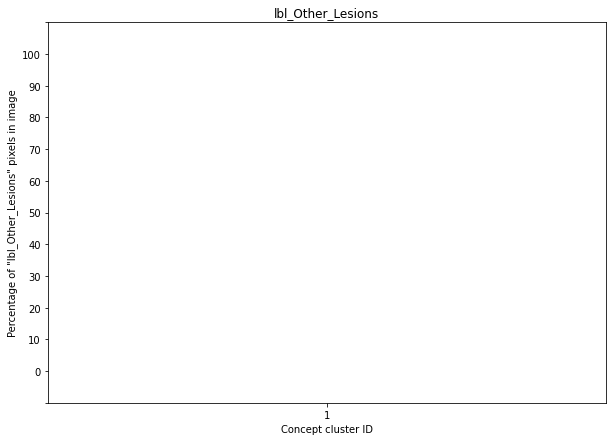

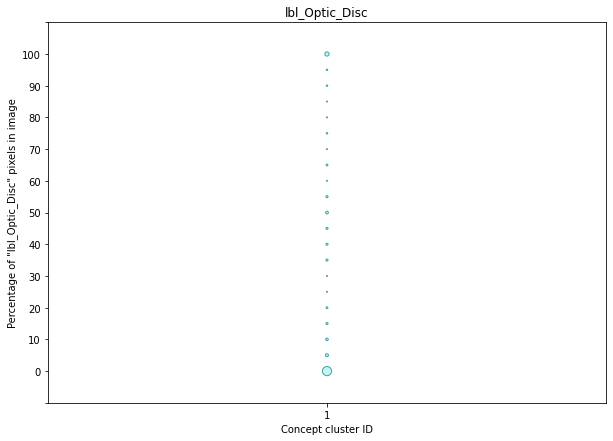

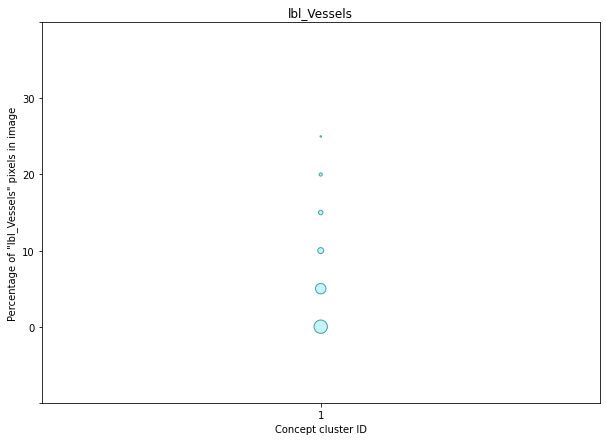

In [19]:
if run_boxplot_evaluation:
    evalutation_via_boxplot()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:17<00:00,  2.58it/s]


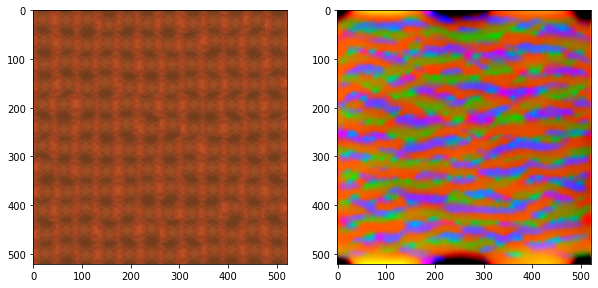

In [25]:
if run_deepdream_evaluation:
    evalutation_via_deepdream()